In [10]:
import numpy as np
import torch
import os
os.chdir("/home/jshenouda/break_test_llms")  # Change to the actual subdirectory name
from train_mnist import MLP
import torch.nn as nn
from torchvision import datasets, transforms
from test_indep import generalized_robust_test

## Corrupts cossine similarity by shifting weight around the MLP

In [11]:
def modify_mlp(model, D_mats= None):
    """Modify an MLP model by applying deep reparameterization ensuring network equivalence."""
    modified_model = MLP(model.model[0].in_features, 
                          [layer.out_features for layer in model.model if isinstance(layer, nn.Linear)][:-1], 
                          model.model[-1].out_features)
    if D_mats is None:
        # controls distortion to mess up cosine sim
        lam = 5

        # Generate the D_k matrices if non given
        D_mats = []
        # count number of ReLU layers
        num_hidden = sum(1 for layer in model.model if isinstance(layer, nn.ReLU))
        for layer in model.model:
            if len(D_mats) == num_hidden:
                break
            if isinstance(layer, nn.Linear):
                max_exp = 30  # Limit exponent growth
                i = torch.linspace(-max_exp, max_exp, layer.out_features)
                D1_values = torch.exp(i)
                D = torch.diag(D1_values)
                # D = torch.diag(torch.tensor([lam**j for j in range(layer.out_features)])).to(torch.float)
                D_mats.append(D)
    
    with torch.no_grad():
        i = 0
        for (orig_layer, new_layer) in zip(model.model, modified_model.model):
            if isinstance(orig_layer, nn.Linear):
                if i < model.affine_layers-1:
                    if i == 0:
                        new_layer.weight.data = torch.inverse(D_mats[0]) @ orig_layer.weight.data
                        new_layer.bias.data = torch.inverse(D_mats[0]) @ orig_layer.bias.data
                    else:
                        new_layer.weight.data = torch.inverse(D_mats[i]) @ orig_layer.weight.data @ D_mats[i-1]
                        new_layer.bias.data = torch.inverse(D_mats[i]) @ orig_layer.bias.data
                else:
                    # For the last linear layer
                    new_layer.weight.data = orig_layer.weight.data @ D_mats[-1]
                    new_layer.bias.data = orig_layer.bias.data

                i += 1

    return modified_model, D_mats


In [12]:
input_dim = 28*28
num_layers = 6
hidden_dims = [100]*num_layers  # 6 hidden layers
output_dim = 10

trained_model = MLP(input_dim, hidden_dims, output_dim)

# Load the trained model
trained_model.load_state_dict(torch.load("mnist_mlp_6_layers.pt"))

<All keys matched successfully>

In [13]:
# Modify the model
modified_model, D_matrices = modify_mlp(trained_model)

In [14]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_data= datasets.MNIST('../data', train=False,
                       transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False)

def ensure_models_equivalent(model1, model2, test_loader, device):
    """Ensure two models produce the same output for all 10,000 test MNIST samples."""
    model1.to(device)   
    model2.to(device)
    model1.eval()
    model2.eval()
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            output1 = model1(data)
            output2 = model2(data)
            
            dist = torch.linalg.norm(output1 - output2, ord='fro')**2
    
    return dist


In [15]:
# Ensure both models are equivalent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(ensure_models_equivalent(trained_model, modified_model, test_loader, device))

tensor(4.4379e-06, device='cuda:0')


In [16]:
# For each weight matrix compare cossine similarity between rows of original weigth matrix and modified weight matrix
def compare_weights(model1, model2):
    with torch.no_grad():
        for (layer1, layer2) in zip(model1.model, model2.model):
            if isinstance(layer1, nn.Linear):
                cos_sim = nn.CosineSimilarity(dim=1)
                sim = cos_sim(layer1.weight, layer2.weight)
                print(sim)

In [17]:
compare_weights(trained_model, modified_model)

tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+

## Testing dependent model that has been adversarially scaled

In [22]:
# Run algo 5 to determine whether trained_model and modified_model are independent
# low phi_match --> dependent
# high phi_match --> independent

## Low phi_match is < 10^{-10}
## High phi_match is uniformly distributed on [0, 1]
phi_matches = []
num_trials = 100
for i in range(num_trials):
    phi_match = generalized_robust_test(trained_model, modified_model, 3)
    print('Phi_match, trial {}: {}'.format(i,phi_match))
    phi_matches.append(phi_match)

Phi_match, trial 0: 0.2289572031211562
Phi_match, trial 1: 0.3410480011046848
Phi_match, trial 2: 0.4147488534122712
Phi_match, trial 3: 0.5713855224247645
Phi_match, trial 4: 0.29872463379453373
Phi_match, trial 5: 0.33406733711285796
Phi_match, trial 6: 0.8666473065817599
Phi_match, trial 7: 0.21295422987530077
Phi_match, trial 8: 0.32701425823197083
Phi_match, trial 9: 0.33333348542169383
Phi_match, trial 10: 0.5464159008987335
Phi_match, trial 11: 0.00894365941600539
Phi_match, trial 12: 0.805484996717724
Phi_match, trial 13: 0.5364940193930473
Phi_match, trial 14: 0.7280986799847264
Phi_match, trial 15: 0.7630743291351696
Phi_match, trial 16: 0.4630822719662432
Phi_match, trial 17: 0.8112080513781876
Phi_match, trial 18: 0.7032094898633872
Phi_match, trial 19: 0.7555186675702286
Phi_match, trial 20: 0.9309605926344972
Phi_match, trial 21: 0.5405410569298903
Phi_match, trial 22: 0.46049385474462534
Phi_match, trial 23: 0.8312040705874487
Phi_match, trial 24: 0.019012475523570438
Ph

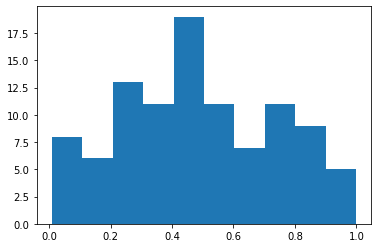

In [23]:
import matplotlib.pyplot as plt
plt.hist(phi_matches, bins=10)
plt.show()

## Testing true independent model

In [24]:
input_dim = 28*28
num_layers = 6
hidden_dims = [100]*num_layers  # 6 hidden layers
output_dim = 10

indep_trained_model = MLP(input_dim, hidden_dims, output_dim)

# Load the trained model
indep_trained_model.load_state_dict(torch.load("indep_mnist_mlp_6_layers.pt"))

<All keys matched successfully>

In [25]:
# Run algo 5 to determine whether trained_model and modified_model are independent
# low phi_match --> dependent
# high phi_match --> independent

## Low phi_match is < 10^{-10}
## High phi_match is uniformly distributed on [0, 1]
phi_matches = []
num_trials = 100
for i in range(num_trials):
    phi_match = generalized_robust_test(trained_model, indep_trained_model, 3)
    print('Phi_match, trial {}: {}'.format(i,phi_match))
    phi_matches.append(phi_match)

Phi_match, trial 0: 0.8985588268491083
Phi_match, trial 1: 0.27470800871415135
Phi_match, trial 2: 0.006900594453299491
Phi_match, trial 3: 0.2796832837260512
Phi_match, trial 4: 0.40011642250714674
Phi_match, trial 5: 0.07698480650606387
Phi_match, trial 6: 0.6261611214099749
Phi_match, trial 7: 0.502458332053942
Phi_match, trial 8: 0.41747717524869055
Phi_match, trial 9: 0.5943309741454186
Phi_match, trial 10: 0.7246972342594405
Phi_match, trial 11: 0.4123475786253541
Phi_match, trial 12: 0.448844459378128
Phi_match, trial 13: 0.8392558400740983
Phi_match, trial 14: 0.9971731668231982
Phi_match, trial 15: 0.8615077651408801
Phi_match, trial 16: 0.3995668136437166
Phi_match, trial 17: 0.5941470909576421
Phi_match, trial 18: 0.9012981595264135
Phi_match, trial 19: 0.48964771968205145
Phi_match, trial 20: 0.7009868232401905
Phi_match, trial 21: 0.9973787830955839
Phi_match, trial 22: 0.15125676757422146
Phi_match, trial 23: 0.8569131464782558
Phi_match, trial 24: 0.11897789496572919
Phi

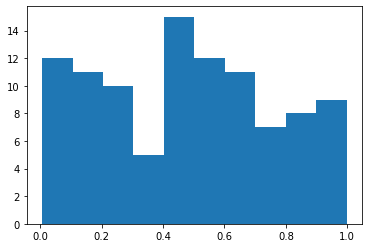

In [26]:
plt.hist(phi_matches, bins=10)
plt.show()

## Try the test with an exact copy of the trained model..

In [27]:
input_dim = 28*28
num_layers = 6
hidden_dims = [100]*num_layers  # 6 hidden layers
output_dim = 10

trained_model_copy = MLP(input_dim, hidden_dims, output_dim)

# Load the trained model
trained_model_copy.load_state_dict(torch.load("mnist_mlp_6_layers.pt"))

<All keys matched successfully>

In [ ]:
# Run algo 5 to determine whether trained_model and modified_model are independent
# low phi_match --> dependent
# high phi_match --> independent

## Low phi_match is < 10^{-10}
## High phi_match is uniformly distributed on [0, 1]
phi_matches_copy = []
num_trials = 100
for i in range(num_trials):
    phi_match = generalized_robust_test(trained_model, trained_model_copy, 3)
    print('Phi_match, trial {}: {}'.format(i,phi_match))
    phi_matches_copy.append(phi_match)

Phi_match, trial 0: 0.16132764918452447
Phi_match, trial 1: 0.014443155741344027
Phi_match, trial 2: 0.005018938548777552
Phi_match, trial 3: 0.0019324570552650133
Phi_match, trial 4: 0.0032628762843519565
Phi_match, trial 5: 0.6399160548970081
Phi_match, trial 6: 0.29757171025899987
Phi_match, trial 7: 0.20024061897610346
Phi_match, trial 8: 0.20077514528107665
Phi_match, trial 9: 0.045529448804567774
Phi_match, trial 10: 0.3737939518796801
Phi_match, trial 11: 0.2100934261820594
Phi_match, trial 12: 0.23072713435982273
Phi_match, trial 13: 0.2437722640692539
Phi_match, trial 14: 0.09916163322275728
Phi_match, trial 15: 0.21371625044637388
Phi_match, trial 16: 0.1735575833090266
Phi_match, trial 17: 0.14977688202807526
Phi_match, trial 18: 0.24545340661840775
Phi_match, trial 19: 0.2053186846160171
Phi_match, trial 20: 0.03962389302743541
Phi_match, trial 21: 0.04068313367875209
Phi_match, trial 22: 0.7090591513294418
Phi_match, trial 23: 0.05407290143311161
Phi_match, trial 24: 0.686